# Residual Networks 
This notebook aims to help gain a better understanding of residual neural networks by defining a residual neural network and plotting the training and validation error of the residual neural network

### Imports

In [1]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

### Import Input Data
Import input data and store it in a variable (data)

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

Successfully loaded data from ./mnist1d_data.pkl


### Separate Training and Validation Data
Separate the imported input data into training and validation data and store it in its respective variables

In [3]:
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']

### Print Validation and Training Data Dimensions

In [4]:
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 4000 examples (columns), each of which has 40 dimensions (rows)


### Initialize Hyperparameters (Input, Output Dimensions)

In [5]:
D_i = 40 # Input dimensions
D_o = 10 # Output dimensions

### Define Residual Neural Network Model Function

In [6]:
class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.linear1(x)
    h2 = h1 + self.linear2(h1).relu()
    h3 = h2 + self.linear3(h2).relu()
    return self.linear4(h3)

### Define He Initialization Function for Weights

In [7]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Define Residual Neural Network Model 
Define a residual neural network with 40 as its input dimensions and 10 as its output dimensions

In [8]:
model = ResidualNetwork(40, 10)

Initialized MLPBase model with 25310 parameters


### Define Cross Entropy Loss
Define the cross entropy loss as the loss function for the defined residual neural network model

In [9]:
loss_function = nn.CrossEntropyLoss()

### Define Stochastic Gradient Descent
Define the stochastic gradient descent as the gradient descent step and initialize the model's learning rate and momentum

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

### Define Scheduler
Define a scheduler that decreases the learning rate by half every 20 epochs

In [11]:
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

### Format Training and Validation Data
Convert the training and validation data into proper format in order to train the residual neural network model

In [12]:
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

### Initialize Batches
Convert the traiing data into batches for the stochastic gradient descent step

In [13]:
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

### Initialize Model Weights

In [14]:
model.apply(weights_init)

ResidualNetwork(
  (linear1): Linear(in_features=40, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=10, bias=True)
)

### Define Epochs
Define the number of times to loop over the entire dataset

In [15]:
n_epoch = 100

### Define Array Structure for Loss and % Correct 
Define four array structures to store the loss and the % correct of the residual neural network for each epoch

In [16]:
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

### Compute Backward Pass
Compute the backward pass for each epoch to compute its gradient and to update the model's parameters based on the computed gradient. Calculate the loss and % correct for each epoch

In [17]:
for epoch in range(n_epoch):
  # Loop over batches
  for i, data in enumerate(data_loader):
    # Retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # Reset the parameter gradients to zero
    optimizer.zero_grad()
    # Compute the forward pass and store the model output
    pred = model(x_batch)
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Undergo the backward pass
    loss.backward()
    # Use the stochastic gradient descent step to update the parameters
    optimizer.step()

  # Calculate statistics for this epoch
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # Initialize scheduler to update learning rate
  scheduler.step()


Epoch     0, train loss 1.671184, train error 64.43,  val loss 1.744571, percent error 66.93
Epoch     1, train loss 1.269246, train error 49.35,  val loss 1.379041, percent error 53.88
Epoch     2, train loss 0.979126, train error 36.12,  val loss 1.187066, percent error 45.12
Epoch     3, train loss 0.869690, train error 32.95,  val loss 1.161195, percent error 43.30
Epoch     4, train loss 0.798068, train error 29.82,  val loss 1.152869, percent error 43.22
Epoch     5, train loss 0.748673, train error 29.38,  val loss 1.146419, percent error 42.42
Epoch     6, train loss 0.667987, train error 24.95,  val loss 1.128411, percent error 39.17
Epoch     7, train loss 0.623544, train error 23.82,  val loss 1.162156, percent error 41.65
Epoch     8, train loss 0.554674, train error 21.00,  val loss 1.167373, percent error 40.47
Epoch     9, train loss 0.506862, train error 19.15,  val loss 1.200638, percent error 39.17
Epoch    10, train loss 0.508588, train error 18.97,  val loss 1.21717

### Plot Model's Error for Training and Validation Data

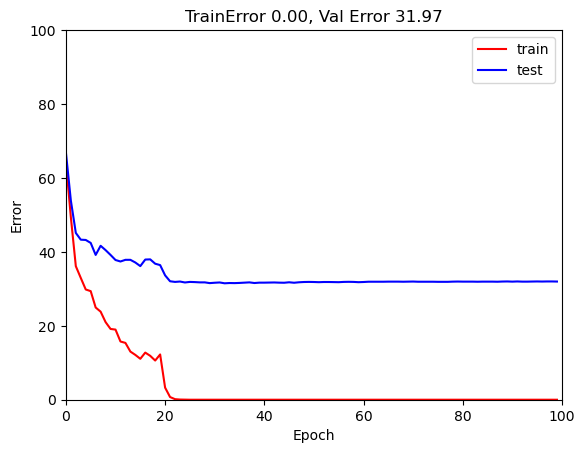

In [18]:
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()